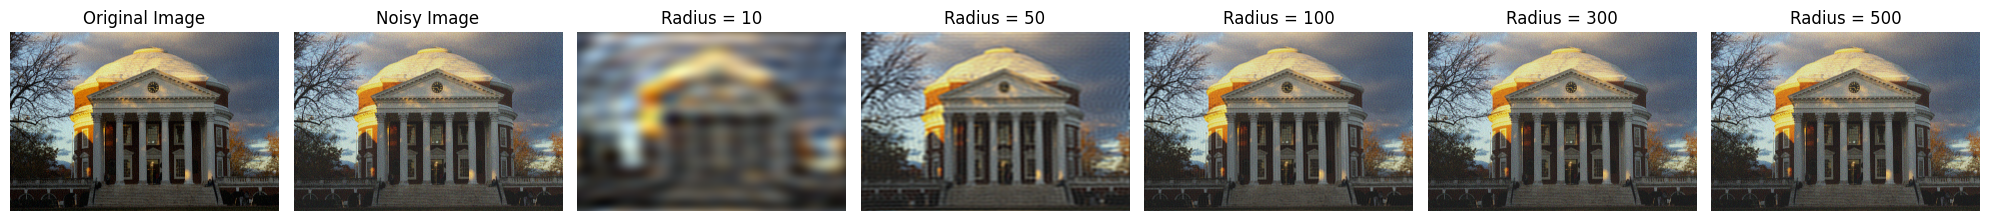

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path):
    """
    Load an RGB image and preprocess it for Fourier Transform.
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return image_rgb

def add_gaussian_noise(image, mean=0, std_dev=25):
    """
    Add Gaussian noise to an image.
    """
    noise = np.random.normal(mean, std_dev, image.shape).astype(np.float32)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def apply_fourier_transform_to_channel(channel):
    """
    Apply 2D Fourier Transform to a single color channel.
    """
    fft = np.fft.fft2(channel)
    fft_shifted = np.fft.fftshift(fft)
    return fft_shifted

def apply_low_pass_filter(fft_shifted, radius):
    """
    Apply a low-pass filter to remove high-frequency components.
    """
    rows, cols = fft_shifted.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.uint8)
    cv2.circle(mask, (center_col, center_row), radius, 1, thickness=-1)  # Circular mask
    filtered_fft_shifted = fft_shifted * mask
    return filtered_fft_shifted

def inverse_fourier_transform(filtered_fft_shifted):
    """
    Perform Inverse Fourier Transform to reconstruct the image.
    """
    fft_unshifted = np.fft.ifftshift(filtered_fft_shifted)
    reconstructed_image = np.abs(np.fft.ifft2(fft_unshifted))
    return reconstructed_image

def process_image_channels(image, radius):
    """
    Process each color channel of the RGB image using Fourier Transform with a given radius.
    """
    reconstructed_channels = []
    for i in range(3):  # Loop through R, G, B channels
        channel = image[:, :, i]
        fft_shifted = apply_fourier_transform_to_channel(channel)
        filtered_fft_shifted = apply_low_pass_filter(fft_shifted, radius)
        reconstructed_channel = inverse_fourier_transform(filtered_fft_shifted)
        reconstructed_channels.append(reconstructed_channel)
    reconstructed_image = np.stack(reconstructed_channels, axis=-1).astype(np.uint8)
    return reconstructed_image

def compare_denoising_with_radii(image, noisy_image, radii):
    """
    Apply denoising using multiple radii and return results.
    """
    denoised_images = []
    for radius in radii:
        denoised_image = process_image_channels(noisy_image, radius)
        denoised_images.append((radius, denoised_image))
    return denoised_images

def plot_all_images_row(original, noisy, denoised_images):
    """
    Display the original, noisy, and denoised images for different radii on the same row.
    """
    num_images = len(denoised_images) + 2  # Include original and noisy images
    plt.figure(figsize=(20, 5))

    # Plot original image
    plt.subplot(1, num_images, 1)
    plt.title("Original Image")
    plt.imshow(original)
    plt.axis('off')

    # Plot noisy image
    plt.subplot(1, num_images, 2)
    plt.title("Noisy Image")
    plt.imshow(noisy)
    plt.axis('off')

    # Plot denoised images for each radius
    for i, (radius, denoised_image) in enumerate(denoised_images):
        plt.subplot(1, num_images, i + 3)
        plt.title(f"Radius = {radius}")
        plt.imshow(denoised_image)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Main Execution
image_path = 'reconstructed_image.jpg'  # Replace with your image path
image_rgb = load_and_preprocess_image(image_path)

# Step 1: Add Gaussian noise to the image
mean = 10
std_dev = 50  # Adjust for noise intensity
noisy_image = add_gaussian_noise(image_rgb, mean=mean, std_dev=std_dev)

# Step 2: Apply Fourier-based denoising with multiple radii
radii = [10, 50, 100, 300, 500]  # Different radii for low-pass filter
denoised_images = compare_denoising_with_radii(image_rgb, noisy_image, radii)

# Step 3: Plot original, noisy, and denoised images in a single row
plot_all_images_row(image_rgb, noisy_image, denoised_images)

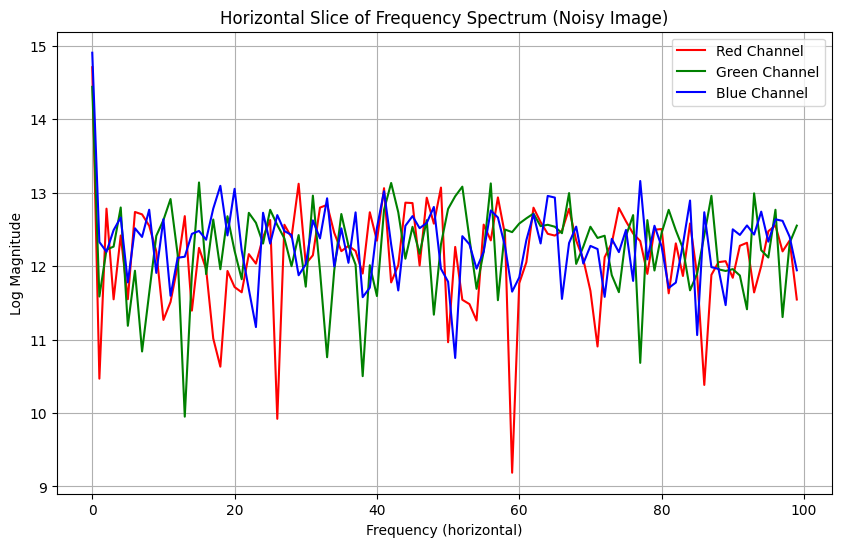

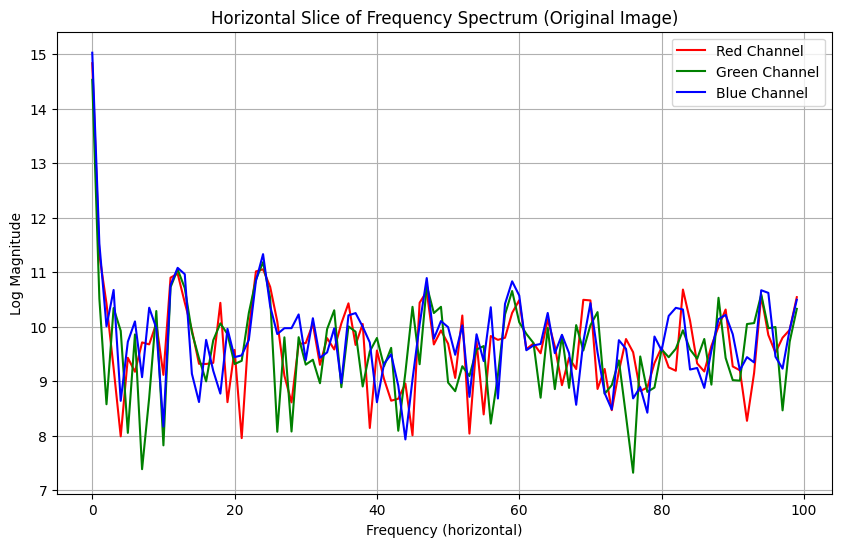

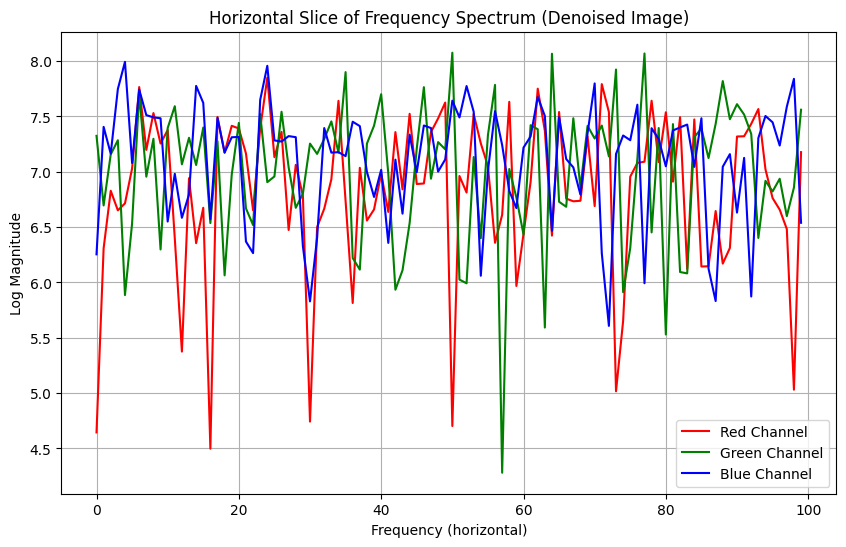

In [12]:
# Function to compute and plot magnitude of horizontal slices for each channel
def plot_horizontal_slices(image, title, zoom_range=None):
    """
    Compute the magnitude of frequency components and plot horizontal slices.
    """
    plt.figure(figsize=(10, 6))

    colors = ['red', 'green', 'blue']
    labels = ['Red Channel', 'Green Channel', 'Blue Channel']

    for i in range(3):  # Loop through RGB channels
        channel = image[:, :, i]
        fft = np.fft.fft2(channel)  # Fourier transform
        fft_shifted = np.fft.fftshift(fft)  # Center the FFT
        magnitude_spectrum = np.log(np.abs(fft_shifted) + 1)  # Log magnitude spectrum

        # Taking the horizontal slice from the middle
        middle_row = magnitude_spectrum[magnitude_spectrum.shape[0] // 2, :]

        if zoom_range:
            plt.plot(range(zoom_range[0], zoom_range[1]),
                     middle_row[zoom_range[0]:zoom_range[1]],
                     label=labels[i], color=colors[i])
        else:
            plt.plot(middle_row, label=labels[i], color=colors[i])

    plt.title(title)
    plt.xlabel('Frequency (horizontal)')
    plt.ylabel('Log Magnitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot magnitude plots for the noisy and denoised images
plot_horizontal_slices(noisy_image, "Horizontal Slice of Frequency Spectrum (Noisy Image)", zoom_range=(0, 100))
plot_horizontal_slices(image_rgb, "Horizontal Slice of Frequency Spectrum (Original Image)", zoom_range=(0, 100))

# If needed, compare with a single channel (e.g., Red) from the denoised image
denoised_image_single = process_image_channels(noisy_image, radius=50)  # Using radius=50 for denoising
plot_horizontal_slices(denoised_image_single, "Horizontal Slice of Frequency Spectrum (Denoised Image)", zoom_range=(0, 100))
